In [66]:
import os
import sys

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = "cuda"
    print("Cuda loaded.")
else:
    print("No cuda warning!")

Cuda loaded.


In [67]:
# Add the parent directory to sys.path
sys.path.append("..")

from utils import *

In [68]:
# Parameters

STUDENT_LR = 1e-2
STUDENT_NUM_ITER = 1000

TEACHER_NUM_ITER = 1000
TEACHER_V = 40

In [69]:
# Load data

data_dir = "../data/"

x_train = torch.load(os.path.join(data_dir, 'x_train.pt')).to(device)
y_train = torch.load(os.path.join(data_dir, 'y_train.pt')).to(device)
x_test = torch.load(os.path.join(data_dir, 'x_test.pt')).to(device)
y_test = torch.load(os.path.join(data_dir, 'y_test.pt')).to(device)  # feasible for small moon data

# Cast to dataset

train_data = CastedDataset(x_train, y_train)
# test_dataset = CastedDataset(x_test, y_test)

In [70]:
# Load wstar

FSTAR = LogisticRegression()
FSTAR.load_state_dict(torch.load(os.path.join(data_dir, 'wstar.pt')))

FSTAR.to(device)

WSTAR = torch.cat([param.data.flatten() for param in FSTAR.parameters()])
WSTAR_NORM = WSTAR / torch.norm(WSTAR)  # for teacher input

In [71]:
# Init student

student = LogisticRegression()
student.load_state_dict(torch.load(os.path.join(data_dir, 'w0.pt')))

student.to(device)

student_optimizer = torch.optim.SGD(
    student.parameters(),
    lr=STUDENT_LR
)

student_log = Log()

In [72]:
# Evaluate student before training

def eval(student, log):

    student.eval()

    w_dist = torch.stack([torch.norm(p1 - p2) ** 2 for p1, p2 in zip(student.parameters(), FSTAR.parameters())]).sum().item()
    train_loss = nn.BCEWithLogitsLoss()(student(x_train), y_train).item()
    test_acc = (((student(x_test) > 0.5) == y_test).sum() / len(y_test)).item()

    log.w_dist.append(w_dist)
    log.train_loss.append(train_loss)
    log.test_acc.append(test_acc)


eval(student, student_log)

In [73]:
# Init teacher

class Teacher(nn.Module):
    def __init__(self, in_dim=10, out_dim=2):
        super().__init__()
        self.emb = nn.Embedding(2, 2)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    
    def forward(self, x, y, w, w_diff):  # expect x, y of batch size 1
        y = self.emb(y.to(torch.long))
        xyw = torch.cat([
            x.squeeze(),
            y.squeeze(),
            w, w_diff
        ])
        return self.mlp(xyw)


teacher = Teacher()
teacher.to(device)

teacher_optimizer = torch.optim.Adam(
    teacher.parameters(),
)

In [74]:
def train_teacher(num_iter, v, teacher, optimizer):

    teacher_loss_list = []
    best_teacher_loss = 1e15
    best_teacher = None
    best_iter = None

    # ===== start of teacher training =====

    for i in (pbar := tqdm(range(num_iter))):

        # ===== init student =====

        student = LogisticRegression()
        student.load_state_dict(torch.load("/home/diana/imt/my/moon_data/moon_w0.pt"))
        student.to(device)

        tracked_param = [p for p in student.parameters()]

        loader = DataLoader(train_data, batch_size=1, shuffle=True)
        iter_loader = iter(loader)

        aux_loss = 0
        tau = 1

        # ===== start of student training =====

        for step in range(v):

            # Get random sample
            try:
                x_old, y = next(iter_loader)
            except:
                iter_loader = iter(loader)
                x_old, y = next(iter_loader)

            # Prepare teacher input
            w = torch.cat([p.data.flatten() for p in student.parameters()])
            w = w / torch.norm(w)

            w_diff = w - WSTAR_NORM

            # Teacher works
            x_new = teacher(x_old, y, w, w_diff)

            # Compute student loss and gradient
            student_loss = nn.BCEWithLogitsLoss()(
                student(x_new),
                y
            )

            student_grad = torch.autograd.grad(
                student_loss,
                student.parameters(),
                create_graph=True
            )

            # Update tracked parameters
            tracked_param = [
                p - STUDENT_LR * g for p, g in zip(tracked_param, student_grad)
            ]

            # Put parameters back to student model
            student.linear.weight = nn.Parameter(tracked_param[0])
            student.linear.bias = nn.Parameter(tracked_param[1])

            # Compute auxilary loss
            tau = tau * 0.95
            aux_loss = aux_loss + tau * nn.BCEWithLogitsLoss()(
                FSTAR(x_new),
                y
            )
        
        # ===== student training end =====

        w_loss = torch.stack([
            torch.norm(p1 - p2) ** 2 for p1, p2 in zip(tracked_param, FSTAR.parameters())
        ]).sum()

        teacher_loss = w_loss + aux_loss
        
        teacher_grad = torch.autograd.grad(
            teacher_loss,
            teacher.parameters()
        )

        for p, g in zip(teacher.parameters(), teacher_grad):
            p.grad = g

        optimizer.step()

        # Update teacher log
        teacher_loss_list.append(teacher_loss.item())

        if teacher_loss.item() < best_teacher_loss:
            best_teacher_loss = teacher_loss.item()
            best_teacher = teacher.state_dict()
            best_iter = i + 1

        pbar.set_description(f"Student {i + 1}, teacher loss = {teacher_loss:.4f}, best_loss = {best_teacher_loss:.4f} at iter {best_iter}")

        # ===== end of teacher training =====

    return best_teacher, teacher_loss_list


In [75]:
best_teacher, teacher_loss_list = train_teacher(TEACHER_NUM_ITER, TEACHER_V, teacher, teacher_optimizer)

Student 1000, teacher loss = 4.4193, best_loss = 4.1722 at iter 519: 100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]


Text(0, 0.5, 'Teacher Loss')

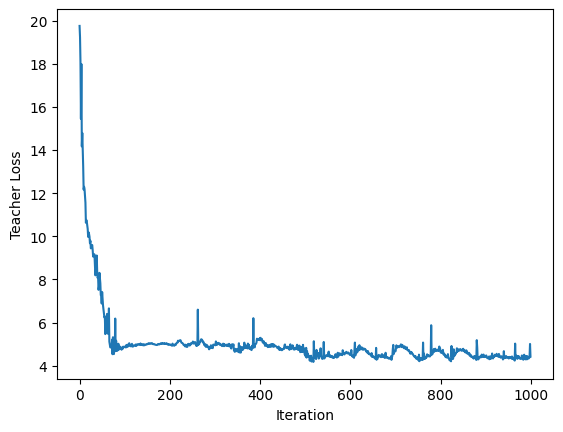

In [76]:
fig, ax = plt.subplots(1, 1)
ax.plot(teacher_loss_list)
ax.set_xlabel("Iteration")
ax.set_ylabel("Teacher Loss")

In [77]:
teacher.load_state_dict(best_teacher)

<All keys matched successfully>

In [78]:
def train_student(num_iter, student, optimizer, log, teacher):

    teacher.eval()

    loader = DataLoader(train_data, batch_size=1, shuffle=True)
    iter_loader = iter(loader)

    for i in (pbar := tqdm(range(num_iter))):

        # Get random sample
        try:
            x_old, y = next(iter_loader)
        except:
            iter_loader = iter(loader)
            x_old, y = next(iter_loader)
        
        # Teacher works
        w = torch.cat([p.data.flatten() for p in student.parameters()])
        w = w / torch.norm(w)

        w_diff = w - WSTAR_NORM

        x = teacher(x_old, y, w, w_diff)

        # Train student
        student.train()

        optimizer.zero_grad()
        loss = nn.BCEWithLogitsLoss()(student(x), y)
        loss.backward()
        optimizer.step()

        # Eval student
        student.eval()

        w_dist = torch.stack([torch.norm(p1 - p2) ** 2 for p1, p2 in zip(student.parameters(), FSTAR.parameters())]).sum().item()
        train_loss = nn.BCEWithLogitsLoss()(student(x_train), y_train).item()
        test_acc = (((student(x_test) > 0.5) == y_test).sum() / len(y_test)).item()

        # Update log
        log.iter += 1
        log.w_dist.append(w_dist)
        log.train_loss.append(train_loss)
        log.test_acc.append(test_acc)

        pbar.set_description(f"Student iter {log.iter}, w_dist = {w_dist:.4f}, train loss = {train_loss:.4f}, test acc = {test_acc:.4f}")

In [79]:
train_student(STUDENT_NUM_ITER, student, student_optimizer, student_log, teacher)

Student iter 1000, w_dist = 4.7192, train loss = 0.4589, test acc = 0.7600: 100%|██████████| 1000/1000 [00:01<00:00, 742.49it/s]


Text(0, 0.5, 'Test Accuracy')

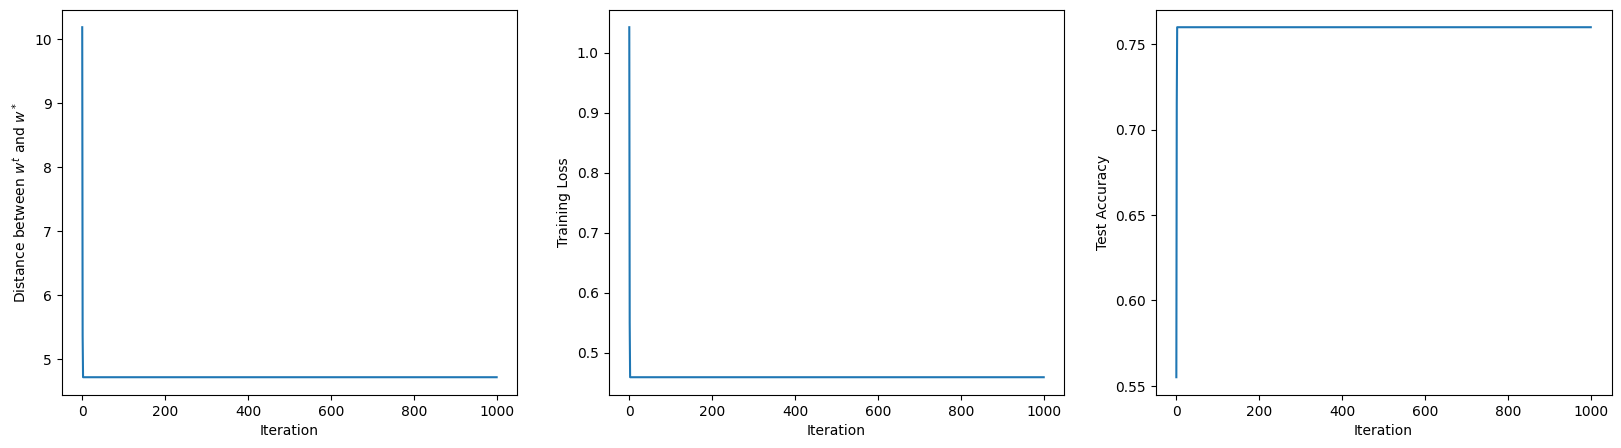

In [80]:
# Plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(student_log.w_dist)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel(f"Distance between $w^t$ and $w^*$")

ax[1].plot(student_log.train_loss)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Training Loss")

ax[2].plot(student_log.test_acc)
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Test Accuracy")

In [82]:
# Save results

results_dir = "../results/"

results = {
    "w": student_log.w_dist,
    "loss": student_log.train_loss,
    "acc": student_log.test_acc
}

np.save(os.path.join(results_dir, 'Parametrised.npy'), results)